In [1]:
import MDAnalysis as mda
from MDAnalysis.transformations import unwrap, center_in_box
import os
import numpy as np
import freud
import matplotlib.pyplot as plt

/home/gabriel/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Change number of lipids

In [2]:
lipids = 256

In [3]:
dir = "/home/gabriel/Dokumente/bachelor_thesis/dpd_simulation/lipid_self_assembly/"
top_file = os.path.join(dir, f"setup/lammps_{lipids}.data")
traj_file = os.path.join(dir, f"assembly/trajectories_{lipids}.lammpstrj")

In [4]:
top_gro_file = os.path.join(dir, f"comparison/popc-bilayer/test/test.tpr")
traj_gro_file = os.path.join(dir, f"comparison/popc-bilayer/test/test.xtc")

In [5]:
top_dpd_file = os.path.join(dir, f"setup/bilayer_{lipids}.data")
traj_dpd_file = os.path.join(dir, f"comparison/comp_{lipids}.lammpstrj")

Fill in correct LAMMPS timestep


In [6]:
u = mda.Universe(top_file, format="DATA", atom_style = "id resid type charge x y z")
u.load_new(traj_file, format="LAMMPSDUMP", dt=0.01)

<Universe with 8801 atoms>

In [7]:
u_gro = mda.Universe(top_gro_file, traj_gro_file)

In [8]:
u_dpd = mda.Universe(top_dpd_file, format="DATA", atom_style = "id resid type charge x y z")
u_dpd.load_new(traj_dpd_file, format="LAMMPSDUMP", dt=0.01)

<Universe with 8798 atoms>

Fill in total number of steps and number of steps in high temperature and cool down phase

In [9]:
steps = 900000
timescale = 91.2 #ps
timestep = u.trajectory.dt
frames = len(u.trajectory)
frame_axis = np.arange(0,frames)
time_per_frame = steps/frames*timestep*(timescale/1000) #ns
steps_per_frame = steps/frames
high_temp = int(220000/steps_per_frame)
cool_down = int(100000/steps_per_frame) + high_temp

## Unwrap molecules, no bonds over box edge

In [10]:
lipid_atoms = u.select_atoms(f"resid 1:{lipids}")

transforms = unwrap(lipid_atoms)
u.trajectory.add_transformations(transforms)

In [11]:
gro_lipid_atoms = u_gro.select_atoms("resname *POPC")

transforms_gro = unwrap(gro_lipid_atoms)
u_gro.trajectory.add_transformations(transforms_gro)

In [12]:
dpd_lipid_atoms = u_dpd.select_atoms(f"resid 1:{lipids}")

transforms_dpd = unwrap(dpd_lipid_atoms)
u_dpd.trajectory.add_transformations(transforms_dpd)

## Contact number

In [13]:
def square_area(box_dims):

    box_dims_list = box_dims.tolist()
    try:
        index_double_occurence = [box_dims_list.count(x) for x in box_dims].index(2)
        area = box_dims[index_double_occurence]**2
    except:
        area = box_dims[0]*box_dims[2]    

    return area

In [14]:
def contact_number(universe, gro=False):

    contact_number = np.zeros(len(universe.trajectory))
    lipid_res = universe.residues[:lipids]
    
    if gro:
        lipid_res = universe.select_atoms("resname POPC*").residues

    for frame_id, frame in enumerate(universe.trajectory):

        box_dims = universe.dimensions[:3]
        coms = np.array([res.atoms.center_of_mass() for res in lipid_res])

        dist_matrix = coms[:,None,:] - coms[None,:,:]
        dist_matrix = dist_matrix - box_dims * np.round(dist_matrix/box_dims)

        dists = np.linalg.norm(dist_matrix, axis=2)
        np.fill_diagonal(dists, np.inf)

        area = square_area(box_dims)

        apl = area/(lipids/2)
        if gro:
            apl = area/64
        cutoff = 2*np.sqrt(apl/np.pi)
        
        neighbor_per_lipid = (dists <= cutoff).sum(axis=1)
        contact_number[frame_id] = np.mean(neighbor_per_lipid)

    return contact_number

In [15]:
self_assembly_contact_number = contact_number(u)

In [16]:
gro_contact_number = contact_number(u_gro, gro=True)
gro_mean_contact = np.mean(gro_contact_number)
gro_std_contact = np.std(gro_contact_number)

In [17]:
dpd_contact_number = contact_number(u_dpd)
dpd_mean_contact = np.mean(dpd_contact_number[150:])
dpd_std_contact = np.std(dpd_contact_number[150:])

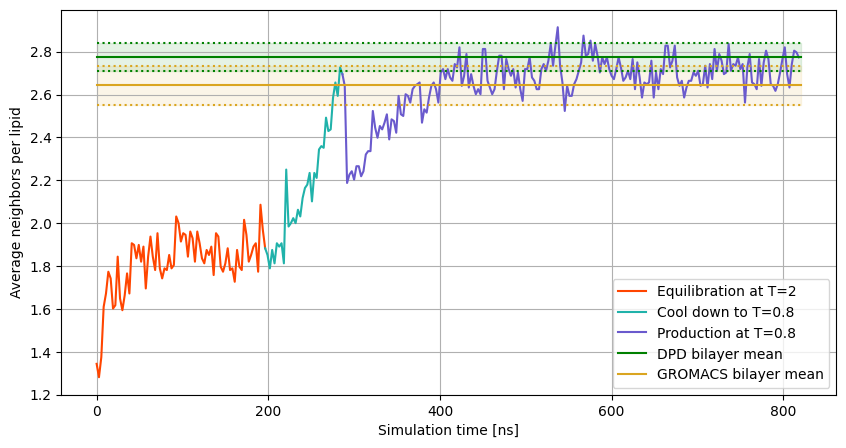

In [18]:
max_time = frames*time_per_frame

plt.figure(figsize=(10,5))

plt.plot(frame_axis[:high_temp]*time_per_frame,self_assembly_contact_number[:high_temp], label="Equilibration at T=2", color="orangered")
plt.plot(frame_axis[high_temp-1:cool_down]*time_per_frame,self_assembly_contact_number[high_temp-1:cool_down], label="Cool down to T=0.8", color="lightseagreen")
plt.plot(frame_axis[cool_down-1:]*time_per_frame,self_assembly_contact_number[cool_down-1:], label="Production at T=0.8", color="slateblue")

plt.plot([0,max_time], [dpd_mean_contact+dpd_std_contact, dpd_mean_contact+dpd_std_contact], linestyle="dotted", color="green")
plt.plot([0,max_time], [dpd_mean_contact,dpd_mean_contact], label="DPD bilayer mean", color="green")
plt.plot([0,max_time], [dpd_mean_contact-dpd_std_contact, dpd_mean_contact-dpd_std_contact], linestyle="dotted", color="green")
plt.fill_between(np.linspace(0,max_time,50), np.full(50, dpd_mean_contact-dpd_std_contact), np.full(50, dpd_mean_contact+dpd_std_contact), color="green", alpha=0.1)

plt.plot([0,max_time], [gro_mean_contact+gro_std_contact, gro_mean_contact+gro_std_contact], linestyle="dotted", color="goldenrod")
plt.plot([0,max_time], [gro_mean_contact,gro_mean_contact],label="GROMACS bilayer mean", color="goldenrod")
plt.plot([0,max_time], [gro_mean_contact-gro_std_contact, gro_mean_contact-gro_std_contact], linestyle="dotted", color="goldenrod")
plt.fill_between(np.linspace(0,max_time,50), np.full(50, gro_mean_contact-gro_std_contact), np.full(50, gro_mean_contact+gro_std_contact), color = "goldenrod", alpha=0.1)

plt.xlabel("Simulation time [ns]")
plt.ylabel("Average neighbors per lipid")
plt.grid()
plt.legend()

## Nematic Order

In [19]:
nematic = freud.order.Nematic()

In [20]:
def neamtic_order(universe,gro=False):

    s_values = np.zeros(len(universe.trajectory))
    directors = np.zeros((len(universe.trajectory), 3))

    lipid_res = universe.residues[:lipids]
    if gro:
        lipid_res = universe.select_atoms("resname POPC*").residues

    for frame_id, frame in enumerate(universe.trajectory):


        orientations = np.zeros((len(lipid_res), 3))

        for mol_id, mol in enumerate(lipid_res):

            positions = mol.atoms.positions
            orientation_long = (positions[7] + positions[11])/2 - positions[0]
            orientations[mol_id] = orientation_long/np.linalg.norm(orientation_long)

        nematic.compute(orientations)

        s_values[frame_id] = nematic.order
        directors[frame_id] = nematic.director

    return s_values, directors

In [21]:
s_values, directors = neamtic_order(u)

In [22]:
gro_s_values, _ = neamtic_order(u_gro, gro=True)
gro_mean_s = np.mean(gro_s_values)
gro_std_s = np.std(gro_s_values)

In [23]:
dpd_s_values, _ = neamtic_order(u_dpd)
dpd_mean_s = np.mean(dpd_s_values)
dpd_std_s = np.std(dpd_s_values)

Fill in correct values for frame flags

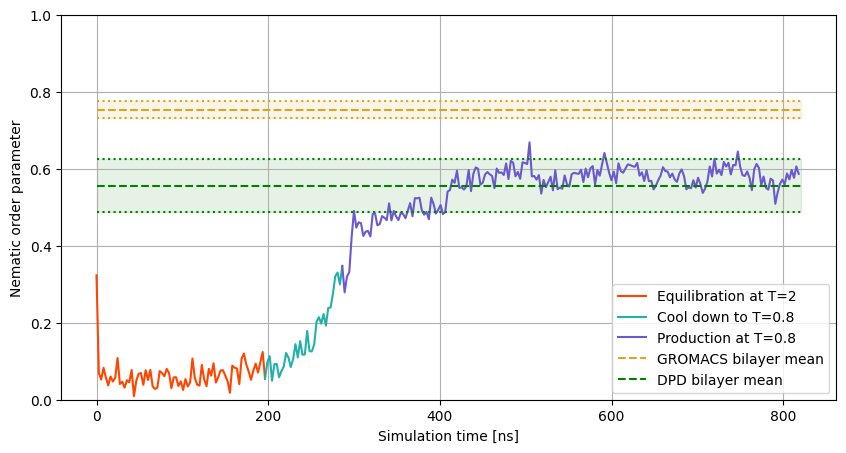

In [24]:
plt.figure(figsize=(10,5))

plt.plot(frame_axis[:high_temp]*time_per_frame,s_values[:high_temp], label="Equilibration at T=2", color="orangered")
plt.plot(frame_axis[high_temp-1:cool_down]*time_per_frame,s_values[high_temp-1:cool_down], label="Cool down to T=0.8", color="lightseagreen")
plt.plot(frame_axis[cool_down-1:]*time_per_frame,s_values[cool_down-1:], label="Production at T=0.8", color="slateblue")

plt.plot([0,max_time], [gro_mean_s-gro_std_s, gro_mean_s-gro_std_s], linestyle="dotted", color="goldenrod")
plt.plot([0,max_time], [gro_mean_s,gro_mean_s], label="GROMACS bilayer mean", linestyle="dashed", color="goldenrod")
plt.plot([0,max_time], [gro_mean_s+gro_std_s, gro_mean_s+gro_std_s], linestyle="dotted", color="goldenrod")
plt.fill_between(np.linspace(0,max_time,50), np.full(50,gro_mean_s+gro_std_s), np.full(50,gro_mean_s-gro_std_s), color="goldenrod", alpha=0.1)

plt.plot([0,max_time], [dpd_mean_s-dpd_std_s, dpd_mean_s-dpd_std_s], linestyle="dotted", color="green")
plt.plot([0,max_time], [dpd_mean_s,dpd_mean_s], label="DPD bilayer mean", linestyle="dashed", color="green")
plt.plot([0,max_time], [dpd_mean_s+dpd_std_s, dpd_mean_s+dpd_std_s], linestyle="dotted", color="green")
plt.fill_between(np.linspace(0,max_time,50), np.full(50,dpd_mean_s+dpd_std_s), np.full(50,dpd_mean_s-dpd_std_s), color="green", alpha=0.1)


plt.ylim((0,1))
plt.xlabel("Simulation time [ns]")
plt.ylabel("Nematic order parameter")

plt.grid()
plt.legend()
plt.show()


## Density profile

In [25]:
def mol_proj_per_beadgroup(molecule, director, lst_heads, lst_links, lst_tails, lst_terminal, lst_mean_head, shift, center):

    positions = molecule.atoms.positions

    tmp = []
    for j in [0,1]:
        proj = np.dot(positions[j] + shift - center, director)
        lst_heads.append(proj)
        tmp.append(proj)
    
    lst_mean_head.append(np.mean(tmp))

    for j in [2,3]:
        proj = np.dot(positions[j] + shift - center, director) 
        lst_links.append(proj)

    for j in [4,5,6,8,9,10]:
        proj = np.dot(positions[j] + shift - center, director) 
        lst_tails.append(proj)

    for j in [7,11]:
        proj = np.dot(positions[j] + shift - center, director) 
        lst_terminal.append(proj)

In [26]:
def center_lst_values(lst1, lst2, lst3, lst4):

    lst1, lst2, lst3, lst4 = np.array(lst1), np.array(lst2), np.array(lst3), np.array(lst4)

    full_lst = np.concatenate([lst1, lst2, lst3, lst4])

    center = np.mean(full_lst)

    lst1 -= center
    lst2 -= center
    lst3 -= center
    lst4 -= center

    return lst1, lst2, lst3, lst4, center

In [27]:
def filter_tails(lst_mean_head, lst_terminal):

    left_terminal = []
    right_terminal = []

    for lipid_id in range(len(lst_mean_head)):

        start = 2*lipid_id
        end = 2*lipid_id + 2
        lipid_terminal = lst_terminal[start:end]

        if lst_mean_head[lipid_id] < 0:
            left_terminal.extend(lipid_terminal)
        else:
            right_terminal.extend(lipid_terminal)
            
    return left_terminal, right_terminal

In [28]:
def make_bins(lsts, n_bins):

    full_lst = []

    for lst in lsts:
        full_lst = np.concatenate([full_lst,lst])

    full_lst = np.array(full_lst) - np.mean(full_lst)

    min, max = np.percentile(full_lst, [1,99])

    min, max = min-1, max+1

    bins = np.linspace(min, max, n_bins+1)
    bin_centers = (bins[:-1] + bins[1:])/2
    bin_width = bins[1] - bins[0]

    return bins, bin_centers, bin_width

In [29]:
def make_hist(lst, bins, bin_width, box_dims, frame_start):

    hist_lst, _ = np.histogram(lst, bins=bins)
    area = square_area(box_dims)
    bin_vol = area*bin_width
    n_frames = frames - frame_start

    hist_lst = hist_lst / (bin_vol*n_frames)

    return hist_lst 

In [30]:
def pbc_correct(lipid_res, box_dims):

    coms = np.array([mol.atoms.center_of_mass() for mol in lipid_res])
    ref = coms[0]

    delta_com = coms - ref
    delta_com = delta_com - box_dims*np.round(delta_com/box_dims)
    coms_unwrapped = delta_com + ref

    bilayer_center = np.mean(coms_unwrapped, axis=0)

    return bilayer_center, coms_unwrapped, coms

In [31]:
def density_profile(universe, frame_start, directors, n_bins):

    proj_heads = []
    proj_links = []
    proj_tails = []
    proj_terminal = []

    proj_heads_per_lipid = []

    directors = np.abs(directors)

    lipid_res = universe.residues[:lipids]

    for frame_id, frame in enumerate(universe.trajectory[frame_start:], frame_start):

        director = directors[frame_id]
        box_dims = universe.dimensions[:3]

        bilayer_center, coms_unwrapped, coms = pbc_correct(lipid_res, box_dims)

        for mol_id,mol in enumerate(lipid_res):
            mol_shift = coms_unwrapped[mol_id] - coms[mol_id]
            mol_proj_per_beadgroup(mol, director, proj_heads, proj_links, proj_tails, proj_terminal, proj_heads_per_lipid, mol_shift, bilayer_center)

    proj_heads, proj_links, proj_tails, proj_terminal, center = center_lst_values(proj_heads, proj_links, proj_tails, proj_terminal)
    proj_heads_per_lipid = np.array(proj_heads_per_lipid) - center

    left_terminal, right_terminal = filter_tails(proj_heads_per_lipid, proj_terminal)
    
    bins, bin_centers, bin_width = make_bins([proj_heads, proj_links, proj_tails, proj_terminal], n_bins)
    bins_ovl, bin_center_ovl, bin_width_ovl = make_bins([left_terminal, right_terminal], n_bins)

    hist_heads = make_hist(proj_heads, bins, bin_width, box_dims, frame_start)
    hist_links = make_hist(proj_links, bins, bin_width, box_dims, frame_start)
    hist_tails = make_hist(proj_tails, bins, bin_width, box_dims, frame_start)
    hist_terminal = make_hist(proj_terminal, bins, bin_width, box_dims, frame_start)

    hist_left = make_hist(left_terminal, bins_ovl, bin_width_ovl, box_dims, frame_start)
    hist_right = make_hist(right_terminal, bins_ovl, bin_width_ovl, box_dims, frame_start)

    return bin_centers, hist_heads, hist_links, hist_tails, hist_terminal, bin_center_ovl, hist_left, hist_right

    


In [32]:
bin_centers, hist_heads, hist_links,hist_tails, hist_terminal, bin_centers_ovl, hist_left, hist_right = density_profile(u, 100, directors, 150)

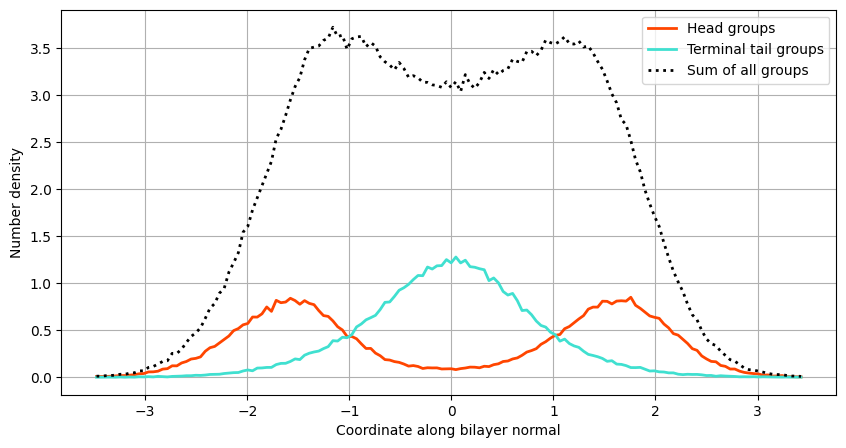

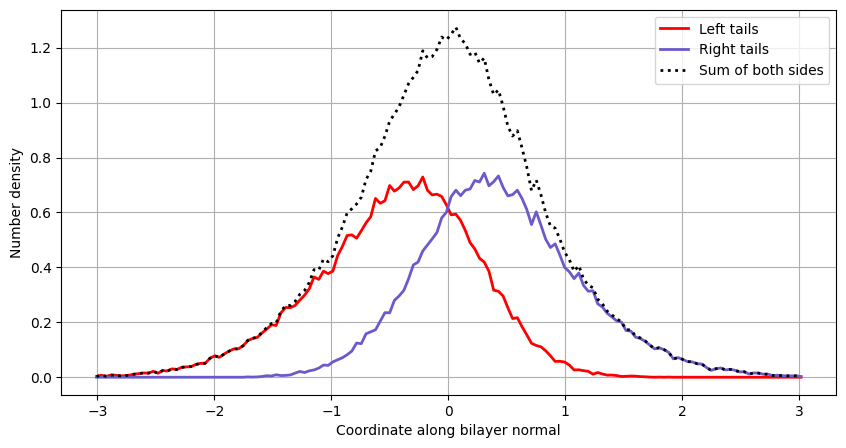

In [33]:
plt.figure(figsize=(10,5))

plt.plot(bin_centers, hist_heads, label='Head groups', linewidth=2, color="orangered")
#plt.plot(bin_centers, links, label='Link groups', linewidth=2)
#plt.plot(bin_centers, tails, label='Tail groups', linewidth=2)
plt.plot(bin_centers, hist_terminal, label='Terminal tail groups', linewidth=2, color="turquoise")
plt.plot(bin_centers, hist_heads+hist_links+hist_tails+hist_terminal, label="Sum of all groups", linewidth=2, linestyle="dotted", color="black")
plt.xlabel("Coordinate along bilayer normal")
plt.ylabel("Number density")

plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(bin_centers_ovl,hist_left, label="Left tails", linewidth=2, color="red")
plt.plot(bin_centers_ovl,hist_right, label="Right tails", linewidth=2, color="slateblue")
plt.plot(bin_centers_ovl,hist_right+hist_left, label="Sum of both sides", linewidth=2, linestyle="dotted", color="black")
plt.xlabel("Coordinate along bilayer normal")
plt.ylabel("Number density")
plt.grid()
plt.legend()

plt.show()